# Laboratorio di Simulazione Numerica
## esercitazione 10

### Esercizio 10.1
In questo esercizio vogliamo risolvere il Problema del commesso Viaggiatore (TSP) usando un algoritmo di ottimizzazione che sfrutta il Simulated Annealing. 

Vogliamo in particolare trovare il percorso di lunghezza minima su circonferenza e nel piano per la stesse configurazioni delle posizioni delle città studiate nell'esercitazione 9. Quindi come posizioni delle città consideriamo quelle nei file *cities_circumference.dat* e *cities_plane.dat* presi dall'esercitazione 9.

Con il Simulated Annealing vogliamo campionare i possibili percorsi del TSP considerandolo come un enseble canonico, con energia data dalla lunghezza dei percorsi. Il campionamento avviene a temperature sempre più basse alla fine l'algoritmo dovrà convergere al minimo della lunghezza.

Per creare il codice di Simulated Annealing riadattiamo semplicemente quello usato per gli algoritmi genetici. In particolare abbiamo ancora la classe **Individual** che contiene il **vector** di interi che con le informazioni sul percorso seguito e i metodi di mutazione. Riadattiamo invece la classe **Population** che serviva per gestire la popolazione. Ora abbiamo una classe **MetropolisSA** che invece di contenere una popolazione di individui ne contine uno solo e invece di avere un metodo per generare una nuova generazione contiene un metodo per eseguire gli step dell'algoritmo di Metropolis.
La classe quindi ha due oggetti **Individual** come mebri, **m_path** e **m_best_path**. **m_path** contiene il percosrso attuale dell'algoritmo di Metropolis, mentre **m_best_path** contiene il percosrso più breve che l'algoritmo ha visitato dall'inizio della simulazione, che sarà poi quello che considereremo come risposta definitiva al TSP.
Ci sono poi due mebri **m_beta** e **m_acceptance**: il primo contiene il valore di $\beta=1/T$ al quale stiamosimulando l'insieme canoninico, l'altro invece contiene il numero di mosse del Metropolis accettate a ogni Step e  ci serve appunto per controllare l'accettazione.
I metodi sono  gli stessi della classe **Population** dell'esercitazione 9, ad eccezione del Metodo **Step** per eseguire l'algoritmo di Metropolis. Sostanzialmente questo metodo prova a eseguire indipendentemente tutte le mutazioni di **individual** implementate nella scorsa esercitazione e ad accettare questa modifica con una probabilità:
$$
p = min\{1,exp(-\beta(L(x') -L(x))\}
$$
Dove $x$ indica l'attuale percorso e $x'$ quello mutato, mentre $L(x)$ è la lunghezza del percorso.

Il codice che poi esegue la simulazione è scritto nel file *SA.cpp* in cui c'è sia la parte per la circonferenza che quella per il piano. La parte importante è quella in cui si scelgono le temperature a cui eseguire la simulazione e quanti step del Metropolis eseguire ad ogni temperatura.
Nella nostra simulazione abbiamo considerato dei valori di $\beta$ che vanno da $1$ a $30$ a intervalli di $1$ e il nummero di step eseguito ad ogni $\beta$ è pari a $N_{step}= 100 \beta$, quindi ad esempio 100 step per il primo valore di $\beta$ e $3000$ step per quello finale. Aumentando  $\beta$ (e quindi diminuendo la temperatura) abbiamo scelto di aumentare il numero di step perchè per le temperature più alte l'accettazione del Metropolis è molto alta e quindi bastano pochi passi per equilibrarsi, mentre a temperature più basse l'accettazione arriva ad avere anche valori del $4\%$ e quindi sono necessarri più passi per equilibrarsi.
Il codice poi stampa sui file "length_circumference.out" e "length_plane.out" i migliori percorsi ottenuti alle diverse temperature di simulazione.

Di seguito sono mostrati i grafici con l'andamento della miglior lunghezza ad ogni valore di $\beta$


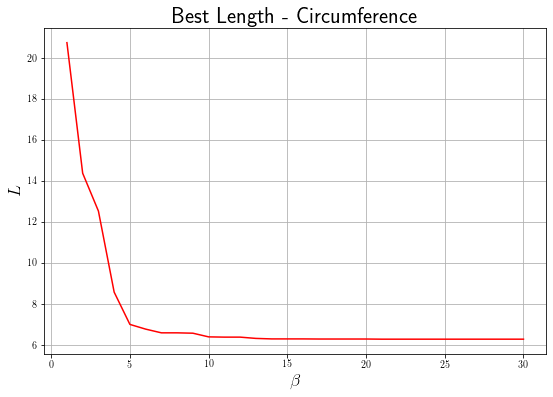

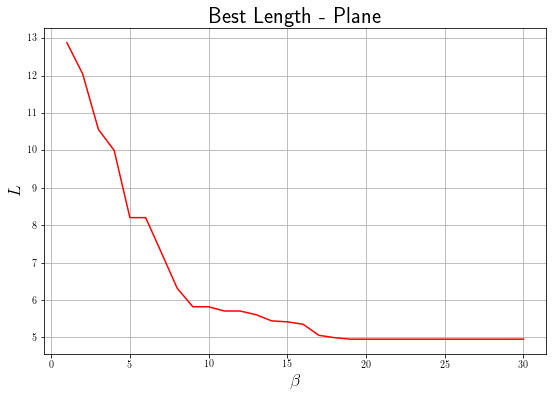

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rc('text', usetex=True)

beta, Circ = np.loadtxt("SimulatedAnnealing/length_circumference.out", usecols = (0,1), delimiter=' ', unpack ='true')
beta, Plane = np.loadtxt("SimulatedAnnealing/length_plane.out", usecols = (0,1), delimiter=' ', unpack ='true')

plt.figure(figsize=(9,6))
plt.plot(beta, Circ, color='red')
plt.xlabel(r'$\beta$', fontsize=18)
plt.ylabel('$L$', fontsize=18)
plt.title('Best Length - Circumference', fontsize=22)
plt.grid(True)
plt.show()

plt.figure(figsize=(9,6))
plt.plot(beta, Plane, color='red')
plt.xlabel(r'$\beta$', fontsize=18)
plt.ylabel('$L$', fontsize=18)
plt.title('Best Length - Plane', fontsize=22)
plt.grid(True)
plt.show()

Nel caso della circonferenza il percorso più breve ha una lunghezza di $6.28319$ cioè $2 \pi$, che è la risposta esatta a questo problema.
Nel caso del piano il percorso più breve ha una lunghezza di $4.94915$. Questi valori sono gli stessi ottenuti nel caso dell'algoritmo genetico dell'esercitazione 9.

Di seguito è mostrato il miglior percorso nel caso del piano.

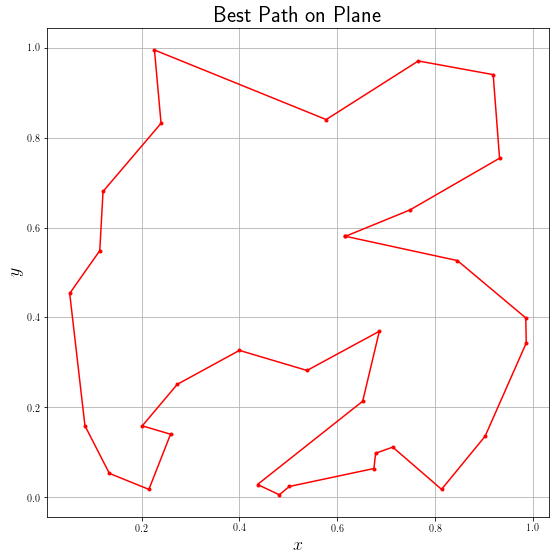

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rc('text', usetex=True)

x, y = np.loadtxt("SimulatedAnnealing/bestPath_plane.out", usecols = (1,2), delimiter=' ', unpack ='true')
x = np.append(x,x[0])
y = np.append(y,y[0])

plt.figure(figsize=(9,9))
plt.plot(x, y, '.-', color='red')
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18)
plt.title('Best Path on Plane', fontsize=22)
plt.grid(True)
plt.show()

### Esercizio 10.2
In questo esercizio vogliamo sfruttare la programmazione in parallelo per rendere più performante il codice di Algoritmo Genetico per il TSP nel piano.

In particolare abbiamo 4 processi (detti *Continenti*) che eseguono indipendente l'evoluzione della popolazione come nella Esercitazione 9, però ogni volta che sono state generate $N_{migr}$ generazioni avviene una migrazione, cioè ogni Continente manda il suo miglior percosrso ad un altro continente.

Per il caloclo in parallelo sfruttano le librerie MPICH. I quattro processi comunichano fra loro utilizzando i comandi di comunicazione MPI_Send e MPI_Recv. Queste comunicazioni sono Bloccani per il singolo processo, però siccome la quantità di dati da scambiare non è elevata (un vettore da 32 interi) questo fatto non genera dei punti moorti durante l'esecuzione.

Per prima cosa vogliamo avere delle genreazioni di partenza diverse per ogni processo, quandi modifichiamo il codice scritto nel file *FirstGen.cpp* dell'esercitazione 9 in modo che produca 4 genrazioni iniziali differenti. Quindi già questo codice è stato adattato alla programmazione in parallelo in modo da avere quattro processi che producono una generazione, ma in ogni processo il generatore di numeri casuali viene impostato con un seme diverso (sfruttando i diversi valori scritti nel file *Primes*). In questo caso i processi non devono comunicare fra loro.
Anche il codice in *TSP.cpp* viene riadattato al calcolo in parallelo e in questo caso dobbiamo anche introdurre le comunicazioni MPI_Send e MPI_Recv per scambiare il vettore di interi contenente il miglior percorso di ogni processo.
Nel nostro caso abbiamo fatto in modo che, durante la migrazione, ogni processo invii il proprio miglior percorso al processo successivo (con l'ordine definito dalla variabile intera **rank** che indica il numero del processo), riceve il miglior percorso del precesso precedente e lo salva al posto del proprio miglior percorso. 

A questo punto si può esegure il codice e analizzare come migliorare il codice di Algoritmo genetico.
Il tempo di esecuzione dell'Algoritmo Genetico dell'esercitazione 9 era già molto basso (di 2 secondi circa) per cui invece che considerare il tempo di esecuzione proviamo a rendere il codice più performante modificando altri parametri. In particolare ciò che cambiamo è il numero di Individui in ciascuna Popolazione e il numero di genrazioni necessarie per arrivare al percorso di lunghezza minima. In particolare le posizioni delle città che stiamo considerando sono le stesse dell'esercitazione 9, per cui sappiamo che la lunghezza del miglior percorso deve essere $4.94915$.

L'evoluzione in questo codice in Parallelo avviene considerando:

- 60 indvidui per popolazione, invece dei 100 del codice non in parallelo.
- 3600 generazioni con una migrazione ogni 250 genreazioni, invece delle 8000 del codice non in parallelo.

Dopo ciascun processo stampa a video la lunghezza del proprio miglior percorso.
Dopo 3600 genrazioni (in cui avvengono 14 migrazioni), tutti e quatrro i processi hanno raggiuinto il percorso di lunghezza minima ($4.94915$). In realtà per trovare la soluzione al problema TSP basterebbero anche meno generazioni. Infatti con 3100 generazioni (12 migrazioni in totale) si osserva che già due dei quattro processi hanno raggiunto il percorso di lunghezza minima.